# INFO371 Problem Set: Feature Transformation & Clustering

## Instructions

* Please write clearly! Answer each question in a way that if the code chunks are removed from your document, the result are still readable!
* Discussing the solutions and getting help is all right, but you have to solve the problem your own. Do not copy-paste from others!
* Make sure you show your work!

---

## Introduction
In this assignment, we are once again going to be looking at the Wisconsin Breast Cancer Dataset (WBCD).
The dataset orginates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) and it contains
569 cases from November 1995.  

The data includes tumor diagnosis, with "M" meaning cancer (malignant) and "B" meaning no cancer (benign), and 10 features describing the physical properties of the cell nuclei from biopsy samples.  Each
feature is represented three times, once for mean, once for standard deviation, and once for the worst values.  More specifically, the variables are: 

* id -> case id
* Diagnosis -> (M = malignant, B = benign).  These are the labels or the part you normally predict . 
* ten real-valued features computed for each cell nucleus. For each feature the mean, standard error, and ''worst'' or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.  For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius. 
   
It contains the following features:
   * radius -> mean of distances from center to points on the
     perimeter
   * texture -> standard deviation of gray-scale values
   * perimeter
   * area
   * smoothness -> local variation in radius lengths
   * compactness -> $ perimeter^2 / area - 1.0$
   * concavity -> severity of concave portions of the contour
   * concpoints -> number of concave portions of the contour
   * symmetry
   * fracdim -> fractal dimension, $coastline\ approximation - 1$


Your task is to predict diagnosis (cancer or not cancer) based on this data, and our focus is to use $k$-NN while also exploring the impact of each feature.

## Baseline Experimental Setup

Before we start experimenting with feature seleciton, its a good idea to establish a baseline performance! To do this, you are welcome to consult your HW4 answers to choose the best K-NN model. 

1. Load the data, Ignore id. 


2. Normalize your features using the StandardScaler() function in the scikit-learn library. For more information see the documentaiton [here](https://scikit-learn.org/stable/modules/preprocessing.html). 



3. Train a K-NN model using the best k-value that gave you the highest average **testing accuracy** scored using cross-validation. If you aren't sure which k-value to choose, repeat the experiments where you run the model with 10-fold cross validation for all k-values between 1-15. For this model, please use the Mahalanobis distance metric. 



4. Report the average accuracy of this model and the runtime. 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("wdbc.csv.bz2")

#code goes here
#1
df = df.drop(['id'], axis=1)
df.head()

,diagnosis,radius.mean,texture.mean,perimeter.mean,area.mean,smoothness.mean,compactness.mean,concavity.mean,concpoints.mean,symmetry.mean,...,radius.worst,texture.worst,perimeter.worst,area.worst,smoothness.worst,compactness.worst,concavity.worst,concpoints.worst,symmetry.worst,fracdim.worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
#2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = df.loc[:, ~df.columns.isin(['diagnosis', 'id'])] 
label = df.diagnosis.to_frame()

label.diagnosis = np.where(label.diagnosis == 'M', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.20)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
#3, 4
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

def cv_model(features, num):
    st = time.time()

    Sigma = np.cov(features, rowvar = False)
    m = KNeighborsClassifier(n_neighbors = num,
                             metric = "mahalanobis",
                             metric_params = {"VI": Sigma})
    m.fit(X_train_std, y_train.values.ravel())
    
    cv = cross_val_score(m, X_test_std, y_test, cv = 10)
    score_test = np.mean(cv) #the average accuracy

    et = time.time()
    
    print("Testing accuracy of Mahalanobis with k = " + str(num) + ": "  +  str(score_test*100) + "%")
    print("Runtime : " + str(et - st))
    print()
    
    return ((et - st), score_test)

best_score = 0
best_k = 0
run_time = 10000
for i in range(1, 16):
    r_time, score_test = cv_model(features, i)
    if best_score < score_test:
        best_score = score_test
        best_k = i
        run_time = r_time

print("The highest average testing accuracy using k = " + str(best_k) + ": " + str(best_score*100) + "%")
print("& its runtime: " + str(run_time) + " seconds")

Testing accuracy of Mahalanobis with k = 1: 87.8030303030303%
Runtime : 0.10881304740905762

Testing accuracy of Mahalanobis with k = 2: 88.56060606060608%
Runtime : 0.07366561889648438

Testing accuracy of Mahalanobis with k = 3: 86.81818181818181%
Runtime : 0.08013319969177246

Testing accuracy of Mahalanobis with k = 4: 85.9090909090909%
Runtime : 0.07740139961242676

Testing accuracy of Mahalanobis with k = 5: 89.39393939393938%
Runtime : 0.08890223503112793

Testing accuracy of Mahalanobis with k = 6: 90.2272727272727%
Runtime : 0.0754399299621582

Testing accuracy of Mahalanobis with k = 7: 89.39393939393939%
Runtime : 0.07755517959594727

Testing accuracy of Mahalanobis with k = 8: 90.3030303030303%
Runtime : 0.08813714981079102

Testing accuracy of Mahalanobis with k = 9: 90.3030303030303%
Runtime : 0.08160138130187988

Testing accuracy of Mahalanobis with k = 10: 89.39393939393939%
Runtime : 0.09547567367553711

Testing accuracy of Mahalanobis with k = 11: 89.39393939393939%
R

## Feature Transformation

Now that you have a baseline performance, your next task is understand what impact each of the features had on model and which features are important. To do this, you'll be writting your own approach for forwards and backwards search. You MAY NOT use any of the feature selection functions in the scikit-learn library -- you need to write these yourself!

6. Write a function for forward search. Your function should accept parameters for the dataset, k-value, and distance metric. Your function should then perform forward search and print at each step the names of the features chosen and the accuracy of the k-nn model run using only those features. Use the testing accuracy reported by 10-fold cross-validation as your metric for scoring features. 


7. Now write a function for backwards search. Your function should accept parameters for the dataset, k-value, and distance metric. Your function should then perform backwards search and print at each step the names of the features chosen and the accuracy of the k-nn model run using only those features. Use the testing accuracy reported by 10-fold cross-validation as your metric for scoring features. 


8. Now use these two funcitons to analyze your dataset! Write/discuss your observations and your analysis (aim for around 2 paragraphs). For example, did any of the results suprise you? How much of an impact did each feature have? Are there differences between the forwards and backwards search results? Did using a smaller feature set decrease the runtime? If so - by how much? Compared to using all the features like you did in the baseline model above, how much of an impact does using a smaller feature set have on overall performance?  


In [4]:
#code goes here
#Note -- feel free to change or add any paramet
#6,7
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def forward_search(data, k):
    m = KNeighborsClassifier(n_neighbors = k)
    m.fit(X_train_std, y_train.values.ravel())
    
    sfs1 = SFS(m,
          k_features = 'best',
          forward = True,
          floating = False,
          verbose = 2,
          scoring = 'accuracy',
          cv = 10)

    sfs1 = sfs1.fit(X_train_std, y_train)
    sele_features = data.columns[1:][list(sfs1.k_feature_idx_)]
    
    X_train_sele = sfs1.transform(X_train_std)
    X_test_sele = sfs1.transform(X_test_std)
    
    st = time.time()
    m.fit(X_train_sele, y_train.values.ravel())
    cv = cross_val_score(m, X_test_sele, y_test, cv = 10)
    score_test = np.mean(cv) #the average accuracy
    et = time.time()
    
    print("Chosen features: ")
    print(sele_features)
    print("Testing Accuracy: " + str(score_test*100) + "%")
    print("Runtime: " + str(et - st) + " seconds")
    
def backwards_search(data, k):
    m = KNeighborsClassifier(n_neighbors = k)
    m.fit(X_train_std, y_train.values.ravel())
    
    sfs1 = SFS(m,
          k_features = 'best',
          forward = False,
          floating = False,
          verbose = 2,
          scoring = 'accuracy',
          cv = 10)

    sfs1 = sfs1.fit(X_train_std, y_train)
    sele_features = data.columns[1:][list(sfs1.k_feature_idx_)]
    
    X_train_sele = sfs1.transform(X_train_std)
    X_test_sele = sfs1.transform(X_test_std)
    
    st = time.time()
    m.fit(X_train_sele, y_train.values.ravel())
    cv = cross_val_score(m, X_test_sele, y_test, cv = 10)
    score_test = np.mean(cv) #the average accuracy
    et = time.time()
    
    print("Chosen features: ")
    print(sele_features)
    print("Testing Accuracy: " + str(score_test*100) + "%")
    print("Runtime: " + str(et - st) + " seconds")
    
forward_search(df, best_k)
backwards_search(df, best_k)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.6s finished

[2023-03-06 03:09:01] Features: 1/30 -- score: 0.9121256038647344[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.9s finished

[2023-03-06 03:09:04] Features: 2/30 -- score: 0.9472463768115942[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.3s finished

[2023-03-06 03:09:06] Features: 3/30 -- score: 0.9581159420289855[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2023-03-06 03:09:22] Features: 30/30 -- score: 0.9647342995169081[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Chosen features: 
Index(['concpoints.mean', 'texture.se', 'area.se', 'concavity.se',
       'fracdim.se', 'texture.worst', 'perimeter.worst', 'area.worst',
       'concpoints.worst'],
      dtype='object')
Testing Accuracy: 97.27272727272727%
Runtime: 0.027906179428100586 seconds


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.5s finished

[2023-03-06 03:09:24] Features: 29/1 -- score: 0.9669565217391304[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.4s finished

[2023-03-06 03:09:25] Features: 28/1 -- score: 0.9691304347826086[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.3s finished

[2023-03-06 03:09:27] Features: 27/1 -- score: 0.9713526570048309[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.3s finished

[2023-03-06 03:09:28] Features: 26/1 -

Chosen features: 
Index(['perimeter.mean', 'concavity.mean', 'fracdim.mean', 'compactness.se',
       'concpoints.se', 'radius.worst', 'texture.worst', 'perimeter.worst',
       'compactness.worst', 'concpoints.worst'],
      dtype='object')
Testing Accuracy: 95.53030303030303%
Runtime: 0.03292274475097656 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2023-03-06 03:09:45] Features: 1/1 -- score: 0.8966666666666667

In [5]:
#8

Using the forward and backwards search on the dataset, the model obtained accuracies of 97.27% and 95.53%, respectively, which are higher than the accuracy of the baseline model (90.30%). Also, the feature selection has improved the runtime of the machine learning model by about 0.061 seconds. This is a significant improvement in the time it takes for the model to make predictions. This suggests that the most relevant features for the classification were selected by these methods which did not surprise me because using a smaller features generally improves the model's overall performance and reduce its runtime.

Furthermore, we can observe that the forward search outperformed the backwards search, which indicates that adding relevant features to the model is more beneficial than removing irrelevant ones. However, it is important that the difference in accuracy between the two methods is not significant, and the choice between forward and backward selection should depend on the specific dataset and classification task. Overall, the feature selection can help improve the performance of machine learning models, especially when dealing with high-dimensional datasets.

## Principal Component Analysis

As we talked about in class, another way we can reduce the dimensions of our dataset is by performing PCA! For this you do not need to write your own PCA algorithm, feel free to use the version in [scikit-learn](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py). 

11. Run a set of experiments using PCA on your features before training your k-nn model. For this, you'll run PCA for all num_components between 2-10. Using the principle components as features, train your k-nn model and report the average accuracy and the runtime. 


12. Using those results, create a two line charts: 1) comparing performance and 2) comparing runtime as you vary the number of components. The number of components should be on the x axis, and your y axis should be accuracy or run time in seconds.


13. Discuss what happens to the accuracy and runtime of your k-nn model as the number of principle components you chose increases/decreases. How does the accuracy/runtime compare to using forwards or backwards search? 

In [6]:
#11
from sklearn.decomposition import PCA

num_components = list(range(2, 11))
acc_list = []
runtime_list = []
for n_cmp in num_components:

    pca = PCA(n_components = n_cmp)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)

    m = KNeighborsClassifier(n_neighbors = best_k)
    
    st = time.time()
    m.fit(X_train_pca, y_train)

    cv = cross_val_score(m, X_test_pca, y_test, cv = 10)
    score_test = np.mean(cv)*100 #the average accuracy
    
    et = time.time()
    
    acc_list.append(score_test)
    runtime_list.append(et - st)
    print("num_component: " + str(n_cmp) + ", " + "accuracy: "  + str(score_test) + "%, " + "runtime: " + str(et - st) + " seconds")

num_component: 2, accuracy: 95.45454545454545%, runtime: 0.03986692428588867 seconds
num_component: 3, accuracy: 94.62121212121211%, runtime: 0.03288888931274414 seconds
num_component: 4, accuracy: 96.36363636363635%, runtime: 0.0348820686340332 seconds
num_component: 5, accuracy: 95.45454545454545%, runtime: 0.039865970611572266 seconds
num_component: 6, accuracy: 94.62121212121211%, runtime: 0.04185962677001953 seconds
num_component: 7, accuracy: 94.62121212121211%, runtime: 0.03189253807067871 seconds
num_component: 8, accuracy: 95.53030303030303%, runtime: 0.04220461845397949 seconds
num_component: 9, accuracy: 94.62121212121211%, runtime: 0.04185986518859863 seconds
num_component: 10, accuracy: 95.45454545454545%, runtime: 0.039865970611572266 seconds


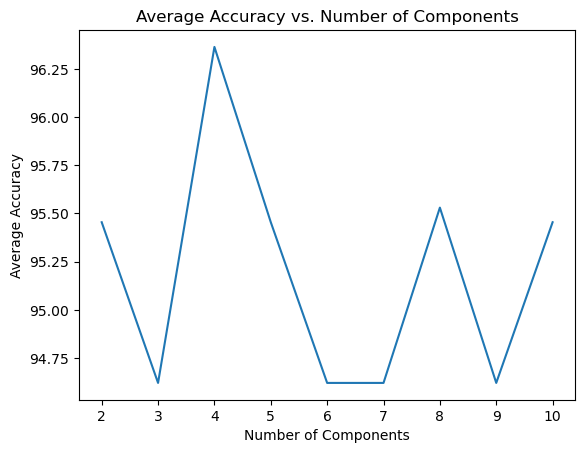

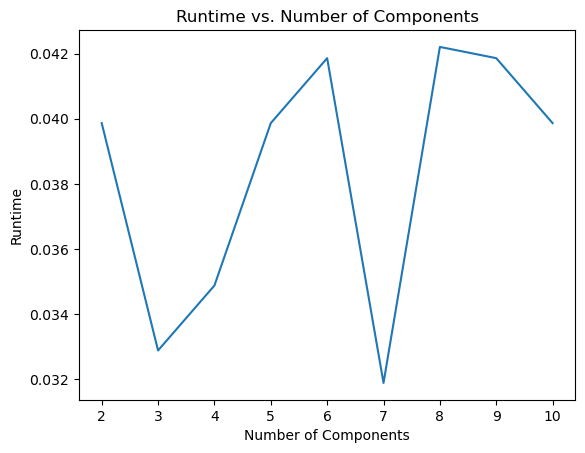

In [7]:
#12
import matplotlib.pyplot as plt
plt.plot(num_components, acc_list)
plt.xlabel('Number of Components')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs. Number of Components')
plt.show()

plt.plot(num_components, runtime_list)
plt.xlabel('Number of Components')
plt.ylabel('Runtime')
plt.title('Runtime vs. Number of Components')
plt.show()

In [8]:
#13

Increasing the number of principal components initially improves the accuracy of the k-NN model, but it results in slower runtime due to increased computation. Therefore, using more components requires more computation, resulting in a slower runtime. Also, in terms of the testing accuracy, PCA is more effective than backwards search, but not as effective as forward search. However, its runtime is generally worse than both search models.